# Introduction

**[AutoRA](https://pypi.org/project/autora/)** (**Au**tomated **R**esearch **A**ssistant) is an open-source framework designed to automate various stages of empirical research, including model discovery, experimental design, and data collection.

This notebook is the fourth of four notebooks within the basic tutorials of ``autora``. We suggest that you go through these notebooks in order as each builds upon the last. However, each notebook is self-contained and so there is no need to *run* the content of the last notebook for your current notebook. We will here provide a link to each notebook, but we will also provide a link at the end of each notebook to navigate you to the next notebook.

[AutoRA Basic Tutorial I: Components](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-I-Components/) <br>
[AutoRA Basic Tutorial II: Loop Constructs](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-II-Loop-Constructs/) <br>
[AutoRA Basic Tutorial III: Workflow Logic](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-III-Workflow-Logic/) <br>
[AutoRA Basic Tutorial IV: Customization](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-IV-Customization/) <br>

These notebooks provide a comprehensive introduction to the capabilities of ``autora``. **It demonstrates the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments.**

**How to use this notebook** *You can progress through the notebook section by section or directly navigate to specific sections. If you choose the latter, it is recommended to execute all cells in the notebook initially, allowing you to easily rerun the cells in each section later without issues.*

## Tutorial Setup
This tutorial is self-contained so that you do not need to run the previous notebook to begin. However, the four notebooks are continuous so that what we define in a previous notebook should still exist within this notebook. As such, we will here re-run relevant code from past tutorials. We will not again walk you through these, but if you need a reminder what they are then go see the descriptions in previous notebooks.

In [ ]:
#### Installation ####
!pip install -q "autora[experimentalist-falsification]"
!pip install -q "autora[theorist-bms]"

#### Import modules ####
import numpy as np
import torch
from autora.variable import DV, IV, ValueType, VariableCollection
from autora.workflow import Controller
from autora.experimentalist.sampler.falsification import falsification_sample
from autora.experimentalist.pooler.random_pooler import random_pool
from autora.theorist.bms import BMSRegressor

#### Set seeds ####
np.random.seed(42)
torch.manual_seed(42)

#### Define ground truth and experiment runner ####
ground_truth = lambda x: np.sin(x)
run_experiment = lambda x: ground_truth(x) + np.random.normal(0, 0.1, size=x.shape)

#### Define condition pool ####
condition_pool = np.linspace(0, 2 * np.pi, 100)
condition_pool = condition_pool.reshape((len(condition_pool), 1))

#### Define data ####
initial_conditions = np.random.choice(np.linspace(0, 2 * np.pi, 100), size=10, replace=False).reshape(-1,1)
initial_observations = run_experiment(initial_conditions).reshape(-1,1)

#### Define metadata ####
iv = IV(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 100))
dv = DV(name="y", type=ValueType.REAL)
metadata = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

#### Define theorists ####
theorist_bms = BMSRegressor(epochs=100)

#### Define monitor ####
def monitor(state):
    print(f"MONITOR: Generated new {state.history[-1].kind}")

# Customizing Automated Empirical Research Components

``autora`` is a flexible framework in which users can integrate their own theorists, experimentalists, and experiment_runners in a automated empirical research workflow. This section illustrates the integration of custom theorists and experimentalists. For more information on how to contribute your own modules to the ``autora`` ecosystem, please refer to the [Contributor Documentation](https://autoresearch.github.io/autora/contribute/modules/).

To illustrate the use of custom theorists and experimentalists, we consider a simple workflow introduced above:
1. Generate 3 seed experimental conditions
2. Iterate through the following steps
   - Collect observations using ``run_experiment``
   - Identify a model relating conditions to observations using ``theorist_bms``
   - Identify 3 new experimental conditions using ``falsification_sample``

In [ ]:
# generate initial pool of 3 experimental conditions
seed_conditions = np.linspace(0,2*np.pi,3)

params = {
        "experimentalist":
                {"condition_pool": condition_pool,
                 "model": "%models[-1]%", # access last model generated by theorist
                 "reference_conditions": "%observations.ivs%", # access all conditions probed so far
                 "reference_observations": "%observations.dvs%", # access all observations collected so far
                 "metadata": metadata,
                 "num_samples": 3}
    }

# define controller
controller = Controller(
    monitor=monitor,
    variables=metadata,
    experimentalist=falsification_sample,
    experiment_runner=run_experiment,
    theorist=theorist_bms,
    params=params,
)

# seed controller
controller.seed(conditions=[seed_conditions])

## Custom Theorists

What if we wanted to replace the ``theorist_bms`` with a custom theorist?

We can implement our theorist as a class that inherits from  `sklearn.base.BaseEstimator`. The class must implement the following methods:

- `fit(self, conditions, observations)`
- `predict(self, conditions)`

The following code block implements such a theorist that fits a polynomial of a specified degree.

In [ ]:
"""
Example Theorist
"""

import numpy as np
from sklearn.base import BaseEstimator


class PolynomialRegressor(BaseEstimator):
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
        self.degree = degree

    def fit(self, conditions, observations):

        # polyfit expects a 1D array
        if conditions.ndim > 1:
            conditions = conditions.flatten()

        if observations.ndim > 1:
            observations = observations.flatten()

        # fit polynomial
        self.coeff = np.polyfit(conditions, observations, 2)
        self.polynomial = np.poly1d(self.coeff)
        pass

    def predict(self, conditions):
        return self.polynomial(conditions)

We can now assign the theorist to a new controller.

In [ ]:
theorist_poly = PolynomialRegressor(degree = 3)

# define controller
controller_with_polynomial_theorist = Controller(
    monitor=monitor,
    variables=metadata,
    experimentalist=falsification_sample,
    experiment_runner=run_experiment,
    theorist=theorist_poly,
    params=params,
)

# seed controller
controller_with_polynomial_theorist.seed(conditions=[seed_conditions])

Let's run the controller with the new theorist for 3 research cycles, defined by the number of models generated.

In [ ]:
from itertools import takewhile

continue_criterion = lambda controller: len(controller.state.models) < 4

for step in takewhile(continue_criterion, controller_with_polynomial_theorist):
    print(f"Number of models: {len(step.state.models)}")

MONITOR: Generated new OBSERVATION
Number of models: 0
MONITOR: Generated new MODEL
Number of models: 1


MONITOR: Generated new CONDITION
Number of models: 1
MONITOR: Generated new OBSERVATION
Number of models: 1
MONITOR: Generated new MODEL
Number of models: 2


MONITOR: Generated new CONDITION
Number of models: 2
MONITOR: Generated new OBSERVATION
Number of models: 2
MONITOR: Generated new MODEL
Number of models: 3
MONITOR: Generated new CONDITION
Number of models: 3
MONITOR: Generated new OBSERVATION
Number of models: 3
MONITOR: Generated new MODEL


We can plot the last model identified by our custom theorist against the ground truth.

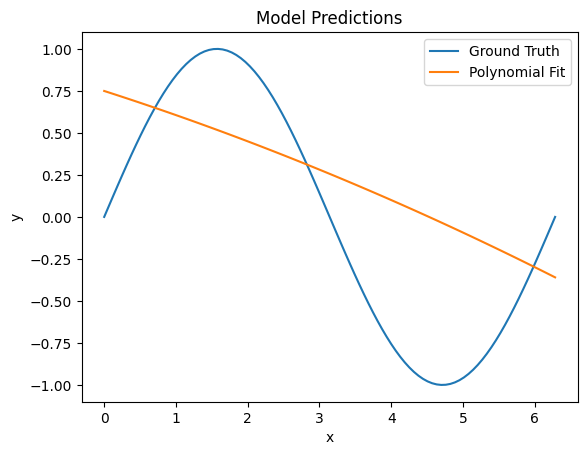

In [ ]:
last_polynomial_model = controller_with_polynomial_theorist.state.models[-1]

predicted_observations_polynomial = last_polynomial_model.predict(condition_pool)

# plot model predictions against ground-truth
import matplotlib.pyplot as plt
plt.plot(condition_pool, ground_truth(condition_pool), label='Ground Truth')
plt.plot(condition_pool, predicted_observations_polynomial, label='Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Predictions')
plt.legend()

## Custom Experimentalists

We can also implement custom experimentalists. Experimentalists are generally implemented as functions that can be integrated into an
[Experimentalist Pipeline](https://autoresearch.github.io/autora/core/docs/pipeline/Experimentalist%20Pipeline%20Examples/). For instance, an experimentalist sampler function expects a pool of experimental conditions–typically passed as a 2D numpy array named ``condition_pool``–and returns a modified set of experimental conditions.

The following code block implements a basic experimentalist that considers two models, and identifies experimental conditions for which the two models differ most in their predictions. This is a special case of the [Model Disagreement Sampler](https://autoresearch.github.io/autora/user-guide/experimentalists/samplers/model-disagreement/).

In [ ]:
def basic_model_disagreement_sample(condition_pool, model_a, model_b, num_samples = 1):

    # get predictions from both models
    prediction_a = model_a.predict(condition_pool)
    prediction_b = model_b.predict(condition_pool)

    # compute mean squared distance between predictions
    disagreement = np.mean((prediction_a - prediction_b) ** 2, axis=1)

    # sort the summed disagreements and select the top n
    selected_conditions_idx = (-disagreement).argsort()[:num_samples]

    return condition_pool[selected_conditions_idx]

We can illustrate our new experimentalist sampler by fitting two different theorists to an initial set of conditions and observations. Here, we consider the BMS theorist and our custom polynomial theorist from above. We then sample 3 experimental conditions using our new experimentalist ``basic_model_disagreement_sample``.

In [ ]:
# fit two theorists
theorist_bms.fit(initial_conditions, initial_observations)
theorist_poly.fit(initial_conditions, initial_observations)

# sample experimental conditions with our custom experimentalist sampler function
selected_conditions = basic_model_disagreement_sample(condition_pool,
                                                theorist_bms,
                                                theorist_poly,
                                                num_samples = 3)

100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


After fitting both theorists, we can compare their predictions across the entire pool of experimental conditions. We will add the sampled experimental conditions to the plot.

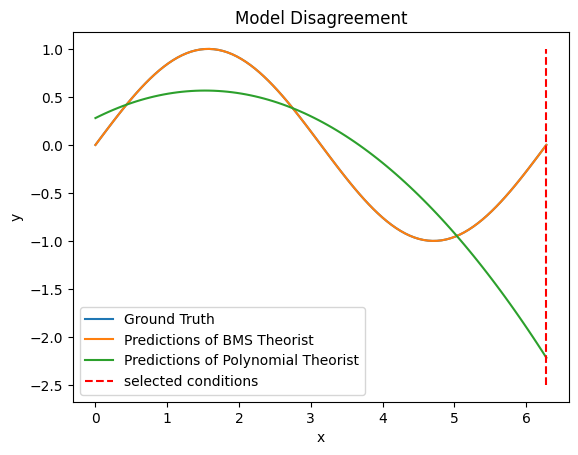

In [ ]:
# plot model predictions against ground-truth
import matplotlib.pyplot as plt

# obtain predictions for both theorists
predicted_observations_bms = theorist_bms.predict(condition_pool)
predicted_observations_poly = theorist_poly.predict(condition_pool)

plt.plot(condition_pool, ground_truth(condition_pool), label='Ground Truth')
plt.plot(condition_pool, predicted_observations_bms, label='Predictions of BMS Theorist')
plt.plot(condition_pool, predicted_observations_poly, label='Predictions of Polynomial Theorist')

y_min = -2.5
y_max  = 1

# plot conditions obtained by novelty sampler
for idx, condition in enumerate(selected_conditions):
    if idx == 0:
        plt.plot([condition[0], condition[0]],
                 [y_min, y_max],
                 '--r', label='selected conditions')
    else: # we want to omit the label for all other conditions
        plt.plot()


plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Disagreement')
plt.legend()

Finally, we can integrate our custom experimentalist and theorist into a closed-loop empirical research workflow, e.g., using basic loop constructs.

In [ ]:
num_cycles = 5 # number of empirical research cycles
measurements_per_cycle = 3 # number of data points to collect for each cycle

# generate an initial set experimental conditions
conditions = random_pool(metadata.independent_variables[0].allowed_values,
                                 n=measurements_per_cycle)
# convert iterator into 2-dimensional numpy array
conditions = np.array(list(conditions)).reshape(-1, 1)

# collect initial set of observations
observations = run_experiment(conditions)

for cycle in range(num_cycles):

  # use BMS theorist and custom polynomial theorist to fit the model to the data
  theorist_bms.fit(conditions, observations)
  theorist_poly.fit(conditions, observations)

  # obtain new conditions from custrom experimentalist sampler
  new_conditions = basic_model_disagreement_sample(condition_pool,
                                                theorist_bms,
                                                theorist_poly,
                                                num_samples = 3)

  # obtain new observations
  new_observations = run_experiment(new_conditions)

  # combine old and new conditions and observations
  conditions = np.concatenate((conditions, new_conditions))
  observations = np.concatenate((observations, new_observations))

  # evaluate model of the theorist based on its ability to predict each observation from the ground truth, evaluated across the entire space of experimental conditions
  loss_bms = np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))
  loss_poly = np.mean(np.square(theorist_poly.predict(condition_pool) - ground_truth(condition_pool)))
  print("Loss of BMS theorist in cycle {}: {}".format(cycle, loss_bms))
  print("Loss of polynomial theorist in cycle {}: {}".format(cycle, loss_poly))

100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Loss of BMS theorist in cycle 0: 0.0
Loss of polynomial theorist in cycle 0: 0.8717052095923039


100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


Loss of BMS theorist in cycle 1: 0.0
Loss of polynomial theorist in cycle 1: 3.619766689361933


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Loss of BMS theorist in cycle 2: 0.0
Loss of polynomial theorist in cycle 2: 0.5193832163876795


100%|██████████| 100/100 [00:07<00:00, 14.26it/s]


Loss of BMS theorist in cycle 3: 0.0
Loss of polynomial theorist in cycle 3: 0.36300053098571583


100%|██████████| 100/100 [00:07<00:00, 13.45it/s]

Loss of BMS theorist in cycle 4: 0.4967273581732591
Loss of polynomial theorist in cycle 4: 0.288261165753893


# Help
We hope that this tutorial helped demonstrate the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments. We encourage you to explore other [tutorials](https://autoresearch.github.io/autora/tutorials/) and check out the [documentation](https://autoresearch.github.io/).

If you encounter any issues, bugs, or questions, please reach out to us through the [AutoRA Forum](https://github.com/orgs/AutoResearch/discussions). Feel free to report any bugs by [creating an issue in the AutoRA repository](https://github.com/AutoResearch/autora/issues).

You may also post questions directly into the [User Q&A Section](https://github.com/orgs/AutoResearch/discussions/categories/using-autora).
